In [1]:
import sys
sys.path.append('../Codes/')
import numpy as np
import matplotlib.pyplot as plt
from Immuno_models import*
#from Bio import Phylo
from io import StringIO
from matplotlib.lines import Line2D
from datetime import datetime, timedelta
import scipy.special as sc
import os.path
import pickle
from matplotlib import style
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from IPython.display import display, Math

def my_linear_func(x, a, b):
    return a + b*x
def my_quadratic_func(x, a, b, c):
    return np.log(a)+np.log(np.sqrt(-b)) + b*(x-c)**2

Text_files_path = '../../../../Dropbox/Research/Evolution_Immune_System/Text_files/'

N_A = 6.02214076e23
k_BT = 1.380649e-23*293
style.use('seaborn-paper')
print(style.available)
%autosave 60

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


Autosaving every 60 seconds


In [2]:
%%time
n_seq = 800000

#Sequences = generate_Sequences(n_seq, Energy_Matrix = )
#pickle.dump( Sequences, open( "../Text_files/Sequences-n_seq-%d.pkl"%(n_seq), "wb" ) )

Sequences = pickle.load( open( Text_files_path + "Sequences_MJ2-n_seq-%d.pkl"%(n_seq), "rb" ) )
print('Master Seq:', Sequences[0].sequence, 'Antigen Seq:', Sequences[0].complementary_sequence, 'Energy_MS:', Sequences[0].energy)

Master Seq: cccccgdcc Antigen Seq: hefqnrihq Energy_MS: -42.650000000000006
CPU times: user 5.75 s, sys: 548 ms, total: 6.3 s
Wall time: 6.37 s


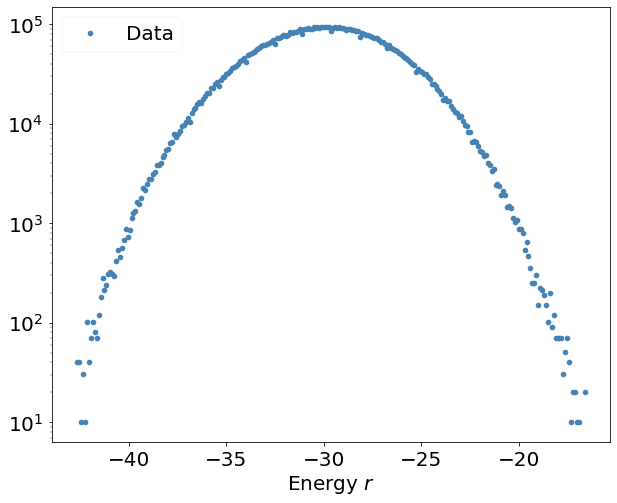

In [5]:
#___________________________________________
fig, ax = plt.subplots(1,1,figsize=(10,8))
distances = plot_histogram_hamming_distance(Sequences = Sequences, ax = ax)
plt.close()
#___________________________________________
fig, ax = plt.subplots(1,1,figsize=(10,8))
energies, data_energies = plot_histogram_energy(Sequences = Sequences, normalization = 1/len(Sequences), bins = 'auto', color = 'steelblue', density = True, ax = ax)
#ax.set_xlim(np.min(energies),np.min(energies)+8 )


In [6]:
%%time
#Left_tail_8 = np.array([Sequences[i] for i in range(int(len(Sequences))) if (Sequences[i].energy < np.min(energies)+8) ])
#pickle.dump( Left_tail_8, open( Text_files_path + "/Sequences_MJ2_left_tail_8-n_seq-%d.pkl"%(int(n_seq)), "wb" ) )
Left_tail_8 = pickle.load(open(Text_files_path + "/Sequences_MJ2_left_tail_8-n_seq-%d.pkl"%(int(n_seq)), "rb" ) )
print(len(Left_tail_8))

65134
CPU times: user 286 ms, sys: 19.1 ms, total: 306 ms
Wall time: 308 ms


In [49]:
#____________ Create sub_energies (uncomment when kernel is restarted)
M = 100
sub_energies = np.array([])
n_ensemble = 60000
for i in range(n_ensemble):
    Sub_Sequences_0 = np.random.choice(Left_tail_8, M)
    sub_energies = np.append(sub_energies,np.array([i.energy for i in Sub_Sequences_0]))
#____________   

31.880587642276662 0.9132798993026916 -47.0444927566741


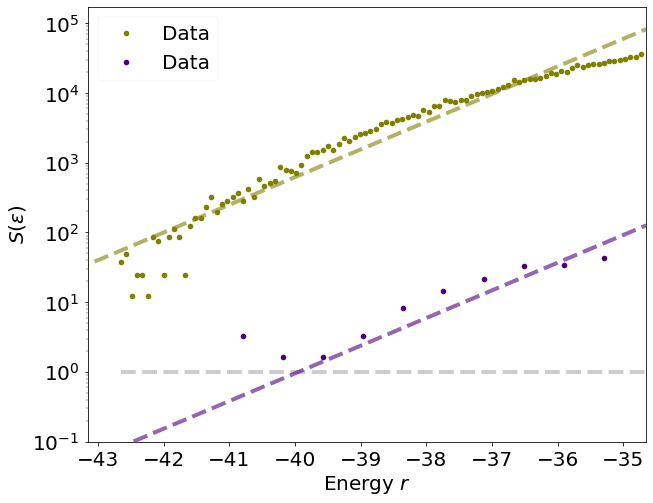

In [50]:
#___________________________________________
fig, ax = plt.subplots(1,1,figsize=(10,8))
distances_left_tail_8 = plot_histogram_hamming_distance(Sequences = Left_tail_8, ax = ax)
plt.close()
#___________________________________________

fig, ax = plt.subplots(1,1,figsize=(10,8))

energies_left_tail_8, data_energies_left_tail_8 = plot_histogram_energy(Sequences = Left_tail_8, normalization = 1/(len(Left_tail_8)), bins = 'auto', color = 'olivedrab', density = True, ax = ax)
sub_energies_left_tail_8, sub_data_energies_left_tail_8 = plot_histogram_energy(Sequences = Sub_Sequences_0, normalization = 1/M , bins = 'auto', color = 'indigo', density = True, ax = ax)

popt, pcov = curve_fit(my_linear_func, data_energies_left_tail_8[1][0:-1][np.where(data_energies_left_tail_8[0]!=0)], np.log(data_energies_left_tail_8[0][np.where(data_energies_left_tail_8[0]!=0)]))

e_new = np.linspace(np.min(energies)-1,np.min(energies)+8,100)

ax.plot(e_new, (len(Left_tail_8))*np.exp(my_linear_func(e_new, *popt)), linestyle  = 'dashed', linewidth = 4, color = 'olivedrab', alpha = .6)
ax.plot(e_new, (M)*np.exp(my_linear_func(e_new, *popt)), linestyle  = 'dashed', linewidth = 4, color = 'indigo', alpha = .6)

ax.hlines(1, np.min(energies),np.min(energies)+8, color = 'grey', alpha = .4, linewidth = 4, linestyle = '--')

ax.set_ylabel(r'$S(\epsilon)$')
ax.set_xlim(np.min(energies)-0.5,np.min(energies)+8 )
ax.set_ylim(bottom=0.1)

b = popt[1]
e_0 = -np.log(len(Left_tail_8)*np.exp(popt[0]))/b
print(*popt, e_0)
fig.savefig('../Figures/Left_tail_energies_after_sampling.png')

In [8]:
delta_KD = np.exp(12)
print(np.log10(delta_KD))

5.211533782839022


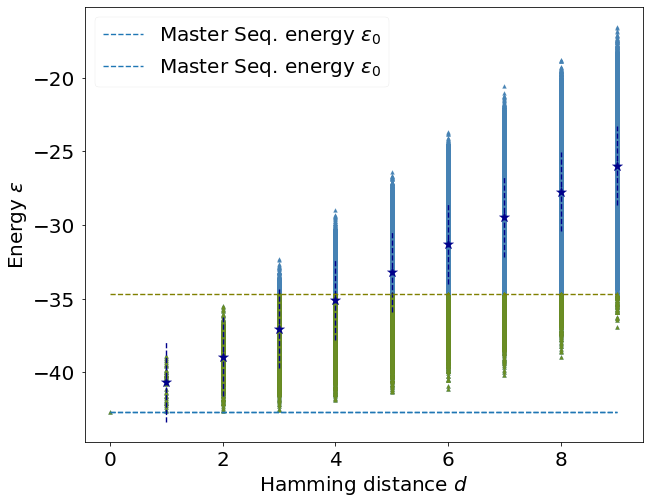

In [97]:
#calculate mean energy given d
mean_energies_given_d = np.array([])

for d in range(1,10):
    temp_array = [Sequences[i].energy for i in range(int(len(Sequences))) if (Sequences[i].hamming_distance == d)]
    mean_energy_given_d = np.mean(temp_array)
    var_energy_given_d = np.var(temp_array)
    mean_energies_given_d = np.append(mean_energies_given_d, mean_energy_given_d)
#-------------------------------------------------- 
#___________________________________________
fig, ax = plt.subplots(1,1, figsize = (10, 8))
plot_scatter_hamming_distance_energy(distances = distances, energies = energies, color = 'steelblue', ax = ax)
plot_scatter_hamming_distance_energy(distances = distances_left_tail_8, energies = energies_left_tail_8, color = 'olivedrab', ax = ax)
ax.scatter(range(1,10), mean_energies_given_d, color = 'darkblue', s = 120, marker = '*')
ax.vlines(range(1,10), mean_energies_given_d-np.sqrt(var_energy_given_d), mean_energies_given_d+np.sqrt(var_energy_given_d), color = 'darkblue', linestyle = '--')
ax.hlines(np.min(energies)+8, 0, 9, color = 'olive', linestyle = '--')
fig.savefig('../Figures/Scatter_sequences_left_tail_8_nseq_%d.png'%(n_seq))


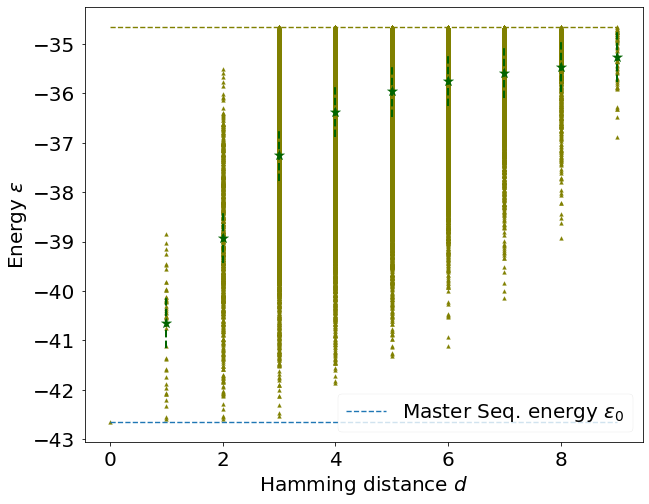

In [98]:
#___________________________________________
fig, ax = plt.subplots(1,1, figsize = (10, 8))

#calculate mean energy given d
mean_energies_given_d = np.array([])

for d in range(1,10):
    temp_array = [Left_tail_8[i].energy for i in range(int(len(Left_tail_8))) if (Left_tail_8[i].hamming_distance == d)]
    mean_energy_given_d = np.mean(temp_array)
    var_energy_given_d = np.var(temp_array)
    mean_energies_given_d = np.append(mean_energies_given_d, mean_energy_given_d)
#-------------------------------------------------- 

plot_scatter_hamming_distance_energy(distances = distances_left_tail_8, energies = energies_left_tail_8, color = 'olive', ax = ax)
ax.hlines(np.min(energies)+8, 0, 9, color = 'olive', linestyle = '--')
ax.scatter(range(1,10), mean_energies_given_d, color = 'darkgreen', s = 120, marker = '*')
ax.vlines(range(1,10), mean_energies_given_d-np.sqrt(var_energy_given_d), mean_energies_given_d+np.sqrt(var_energy_given_d), color = 'darkgreen', linestyle = '--', linewidth = 2)

fig.savefig('../Figures/Scatter_left_tail_8_nseq_%d.png'%(n_seq))


In [93]:
20**6

64000000

## Single run

0.0015352964657475358
to =  6.001959977177469
CPU times: user 4.47 s, sys: 51.3 ms, total: 4.52 s
Wall time: 4.55 s


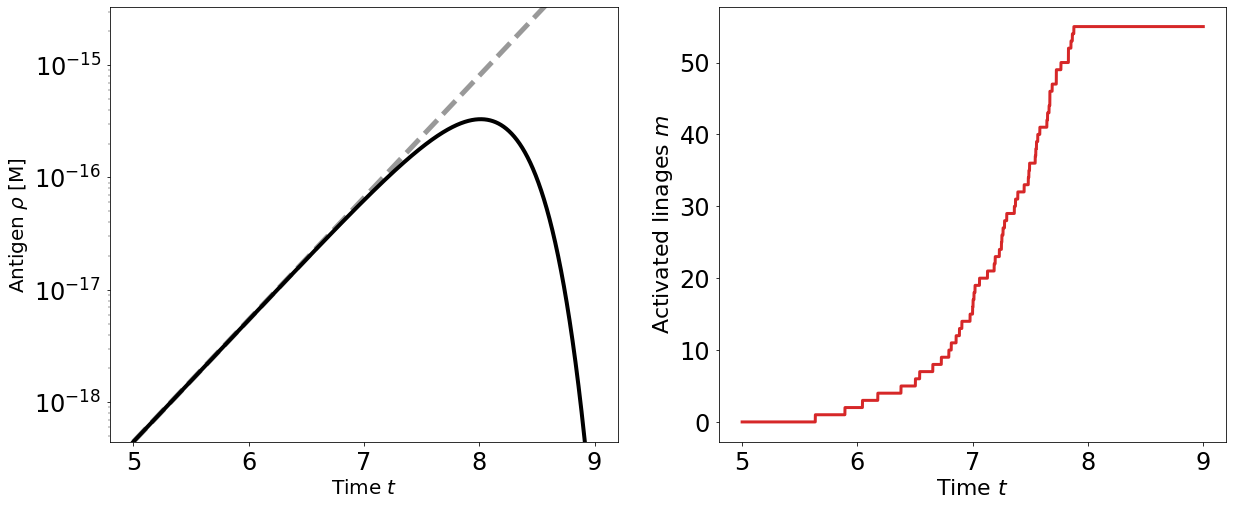

In [136]:
%%time
M = 100
U = M/n_seq
alpha = M/len(Left_tail_8)
print(alpha)
nu = 2.5
beta = 2.5
gamma = 0.002
T = 9
energy_translation = 0
initial_time = 5
dt = 0.001
to = (np.min(energies) + energy_translation + np.log(N_A))/beta
print('to = ', to)
Sub_Sequences = np.random.choice(Left_tail_8, M)
for i in range(M):
    Sub_Sequences[i].active = False
Model  = Deterministic_simulation(Sequences = Sub_Sequences, n_linages=M, T = T,
                                  U = U, nu = nu, beta = beta, gamma = gamma,
                                  energy_translation = energy_translation,
                                  initial_time = initial_time, dt = dt)
Model.ODE()

fig, ax = plt.subplots(1,2,figsize=(20,8))
Model.plot_antigen_time(color = 'black', ax = ax[0])
ax[0].set_ylim(np.exp(Model.beta*initial_time)/N_A, (np.max(Model.antigen_time_series)/N_A)*10)
ax[0].plot(Model.time_series, np.exp(Model.time_series*beta)/Model.N_A, linewidth = 5, linestyle = 'dashed', alpha = 0.4, color = 'black')
ax[0].tick_params(labelsize = 24)
m_t = np.sum(Model.activation_time_series, axis=0)
ax[1].plot(Model.time_series, m_t, linewidth = 3, color = 'tab:red')
ax[1].set_xlabel(r'Time $t$', fontsize = 22)
ax[1].set_ylabel(r'Activated linages $m$', fontsize = 22)
ax[1].tick_params(labelsize = 24)
#fig.savefig('../Figures/antigen_linages_dynamics_example.png')

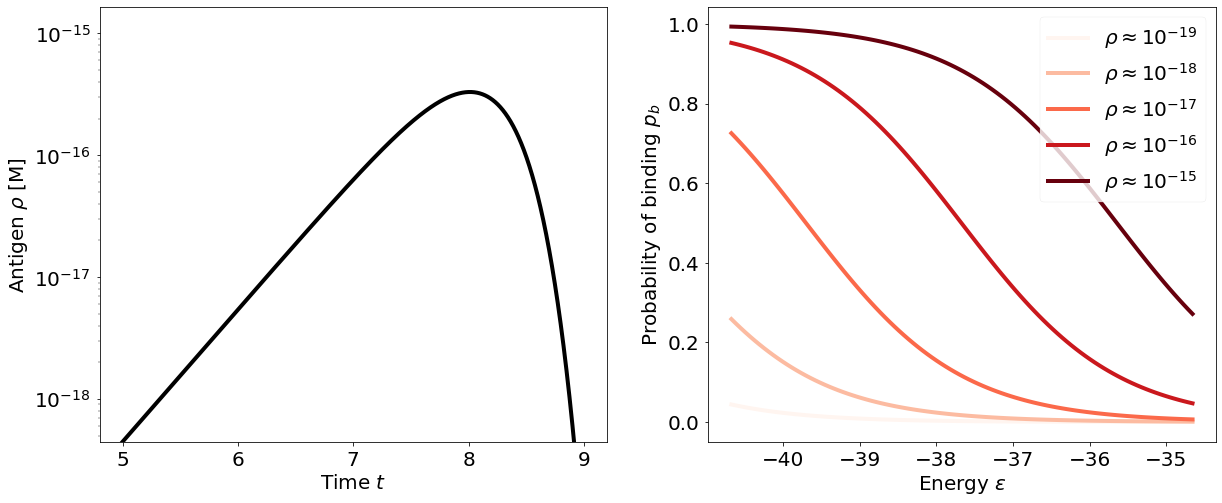

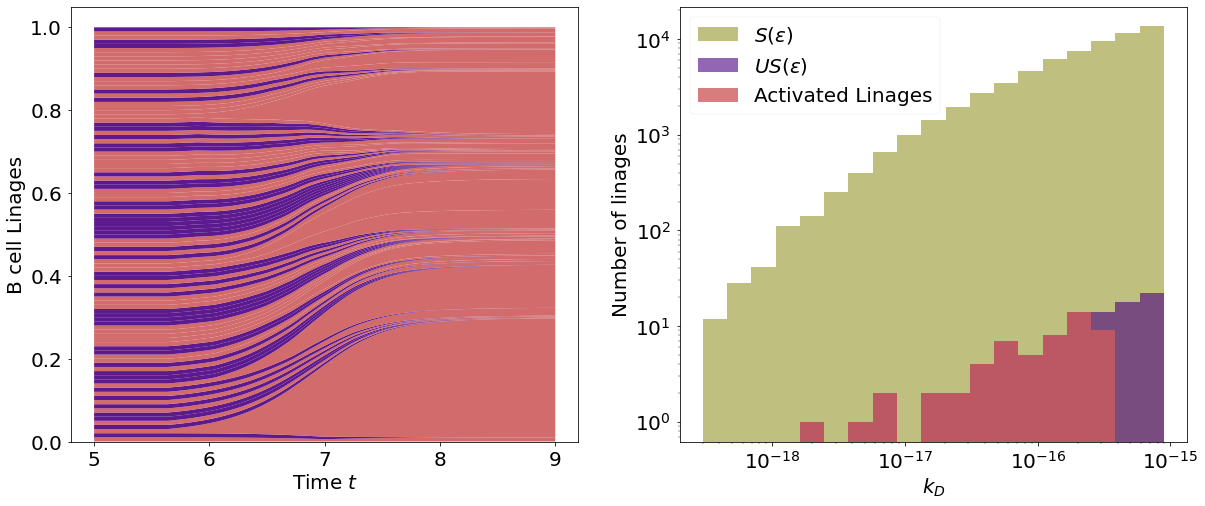

In [137]:
fig, ax = plt.subplots(1,2,figsize=(20,8))
Model.plot_antigen_time(color = 'black', ax = ax[0])
Model.plot_prob_binding(ax = ax[1])
ax[1].set_yscale('linear')
counter = 0
while(os.path.isfile('../Figures/Antigen_Binding_%d.png'%(counter))):
    counter+=1
fig.savefig('../Figures/Antigen_Binding_example_%d.png'%(0))
#--------------------------------------------------------------------------------------------------------------------
fig, ax = plt.subplots(1,2,figsize=(20,8))
Model.stackplot_linages_time(antigen = False, time = True, ax = ax[0])

Model.hist_sequences_k_D(Sequences = Left_tail_8, n_bins = 20, ax = ax[1])
ax[1].set_xscale('log')
ax[1].set_xlabel(r'$k_D$', fontsize = 20)
counter = 0
counter = 0
while(os.path.isfile('../Figures/Linages_%d.png'%(counter))):
    counter+=1
fig.savefig('../Figures/Linages_example_%d.png'%(0))


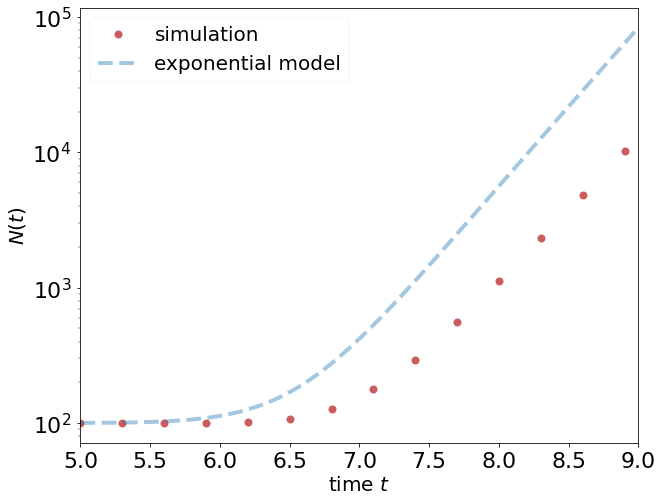

In [53]:
popt = np.array([ 1.35847161e+05, -4.92212036e-02, -2.79453873e+01])

fig, ax = plt.subplots(1,1,figsize=(10,8))
t_new = np.linspace(initial_time, T, int((T/dt)))
ax.plot(Model.time_series[::300], np.sum(Model.linages_time_series, axis=0)[::300], marker = 'o', ms = 8, color = 'indianred', linestyle = '', label = 'simulation')

#to = (e0 + np.log(N_A))/beta
to = (np.min(energies) + energy_translation + np.log(N_A))/beta
tau = np.exp(t_new-to)
N_total_exp = ((1*(tau**(beta*b)-tau**(nu)))/(beta*b-nu)) + M - (1/(beta*b))*(tau**(beta*b)-1)
ax.plot(t_new, N_total_exp, linewidth = 4, linestyle = 'dashed', alpha = 0.4, label = 'exponential model')

ax.set_xlabel(r'time $t$', fontsize = 20)
ax.set_ylabel(r'$N(t)$', fontsize = 20)
ax.tick_params(labelsize = 22)
ax.set_yscale('log')
ax.set_xlim(initial_time, T)
ax.legend(loc = 0, fontsize = 20)
counter = 0
while(os.path.isfile('../Figures/N_total_%d.png'%(counter))):
    counter+=1
#fig.savefig('../Figures/N_total_%d.png'%(0))


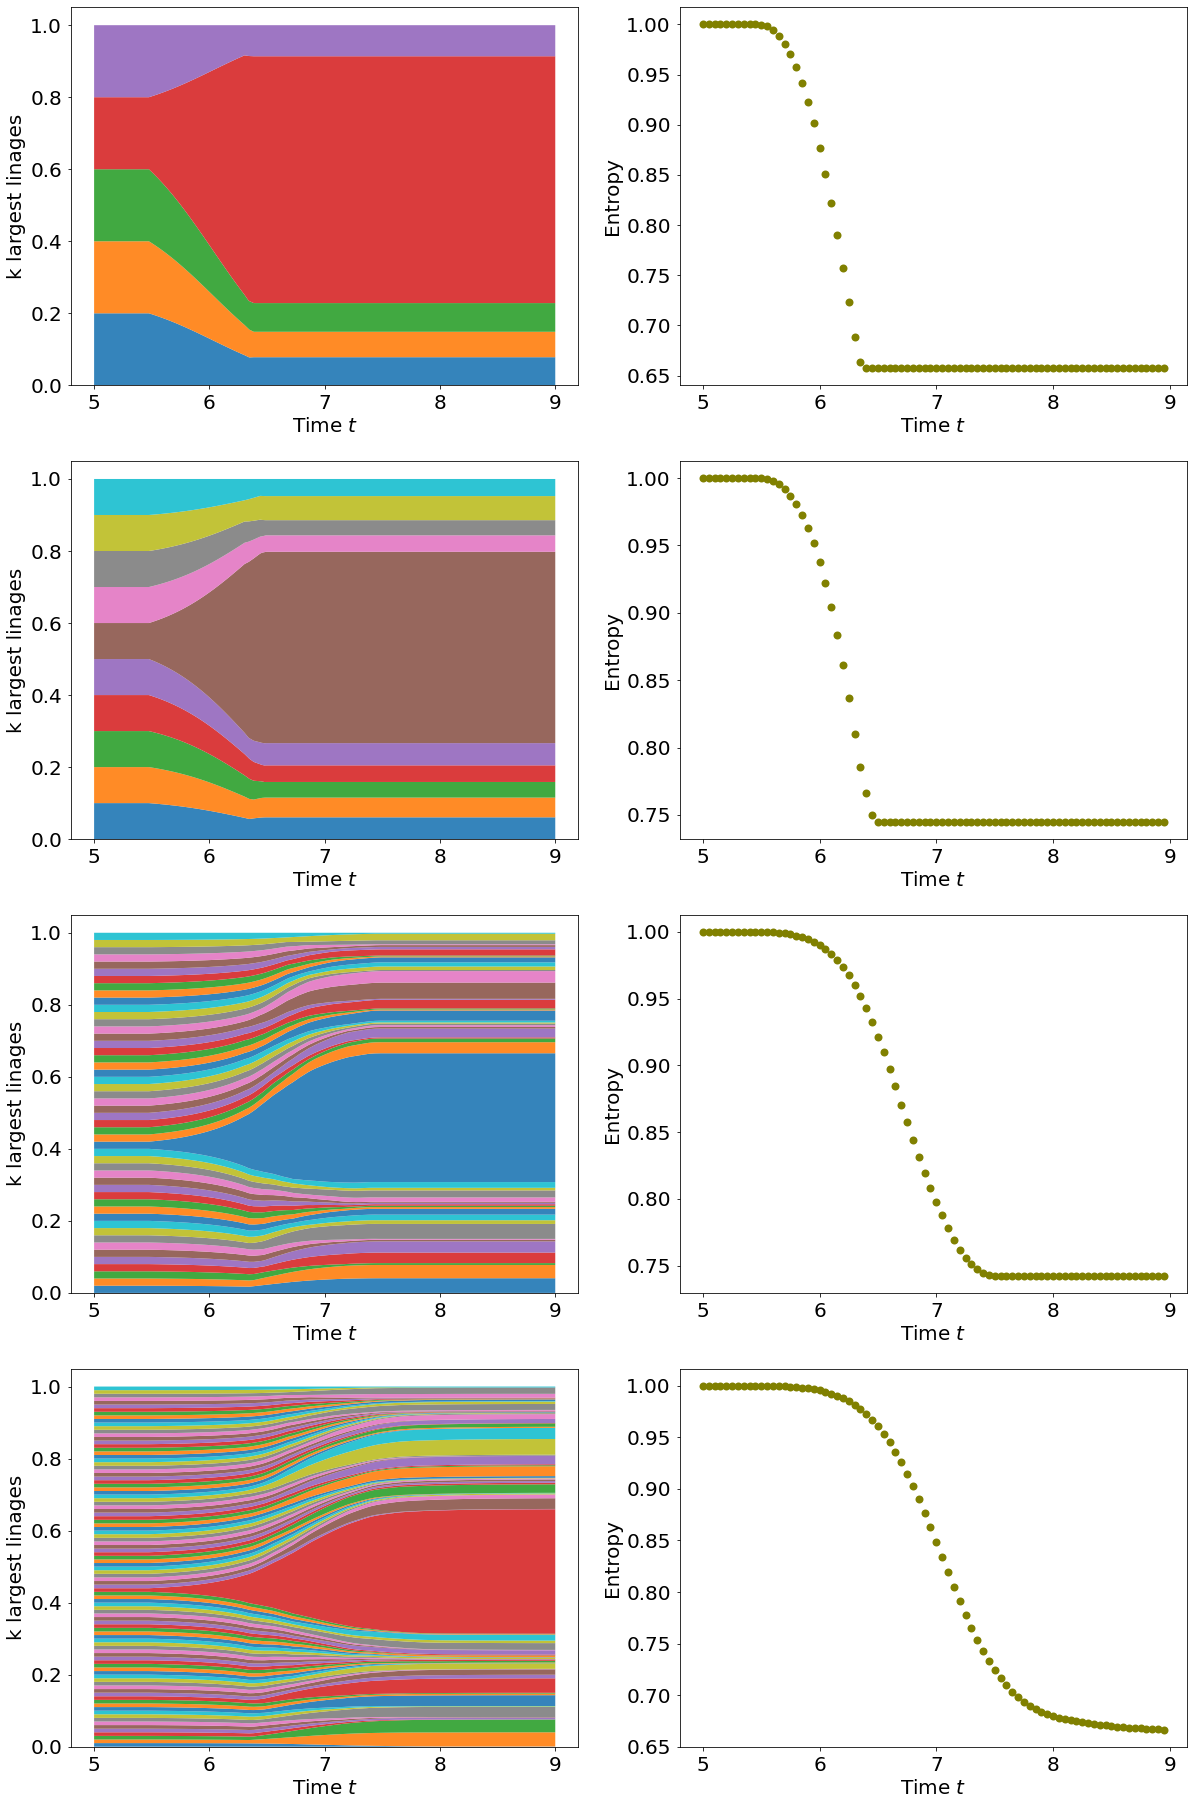

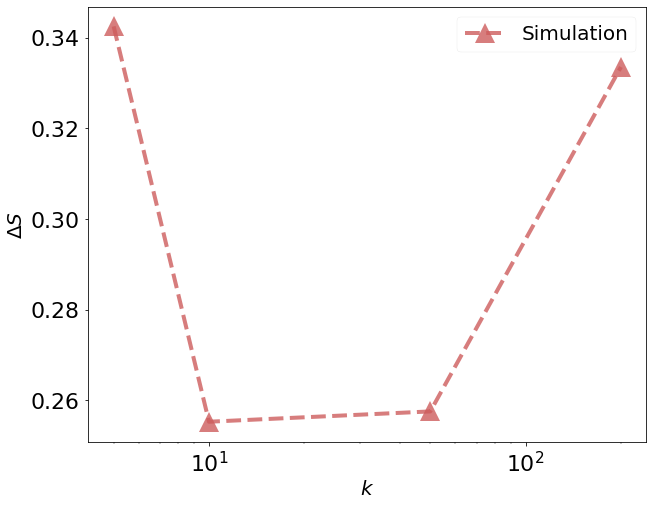

In [61]:
fig1, ax1 = plt.subplots(4,2,figsize=(20,32))
fig2, ax2 = plt.subplots(1,1,figsize=(10,8))
k_array = np.array([0, 5, 10, 50, 200])
Model.plot_entropy_drop(k_array = k_array, ax1 = ax1, ax2 = ax2)

counter = 0
while(os.path.isfile('../Figures/Muller_plots_entropy_%d.png'%(counter))):
    counter+=1
#fig1.savefig('../Figures/Muller_plots_entropy_%d.png'%(0))

counter = 0
while(os.path.isfile('../Figures/Entropy_drop_%d.png'%(counter))):
    counter+=1
#fig2.savefig('../Figures/Entropy_drop_%d.png'%(0))


## Preliminaries for memory

(array([0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 array([-40.67      , -40.11777778, -39.56555556, -39.01333333,
        -38.46111111, -37.90888889, -37.35666667, -36.80444444,
        -36.25222222, -35.7       ]),
 <BarContainer object of 9 artists>)

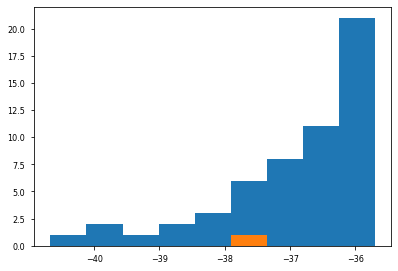

In [145]:

activated_seqs = [Model.Sequences[i] for i in range(int(len(Model.Sequences))) if Model.Sequences[i].active == True]
energies = [i.energy for i in activated_seqs]
gc_seqs = np.array([])
for i in range(int(len(energies))):
    r = np.random.random()
    if (r<.01):
        gc_seqs = np.append(gc_seqs, activated_seqs[i])
        
energies_GC = [i.energy for i in gc_seqs]
plt.hist(energies, bins = np.linspace(min(energies), max(energies), 10))
plt.hist(energies_GC, bins = np.linspace(min(energies), max(energies), 10))


## Ensemble

In [248]:
%%time
n_linages = 200
U = n_linages/n_seq
alpha = n_linages/len(Left_tail)
energy_translation = 0
initial_time = 3.5
dt = 0.001
T = 6 #Use 5 for only growth and 6 for growth and death
n_sim = 1000

betas = np.linspace(2.5, 3.5, 5)
betas = [np.linspace(2.5, 3.5, 5)[2]]
gammas = np.logspace(-2, 0, 5)
gammas = [np.logspace(-2, 0, 5)[2]]
nus = np.linspace(.5, 4.5, 5)
nus = [np.linspace(.5, 4.5, 5)[3]]

for beta in betas:
    for gamma in gammas:
        for nu in nus:
            comment = 'left_tail_800k_birth_death_beta_%.2f_gamma_%.2e_nu_%.2f'%(beta, gamma, nu)

            run_ensemble_deterministic_model(Sequences = Left_tail, n_linages = n_linages, n_seq = 800000, nu = nu, beta = beta,
                                             gamma = gamma, T = T, energy_translation = energy_translation, initial_time = initial_time,
                                             dt = dt, n_sim = n_sim, comment = comment, new = False)


0 ...
200 ...
400 ...
600 ...
800 ...
Ensemble size: 25344
CPU times: user 1h 52s, sys: 12.9 s, total: 1h 1min 5s
Wall time: 1h 1min 11s


4.034966647647889 3.0015138164678724e-19


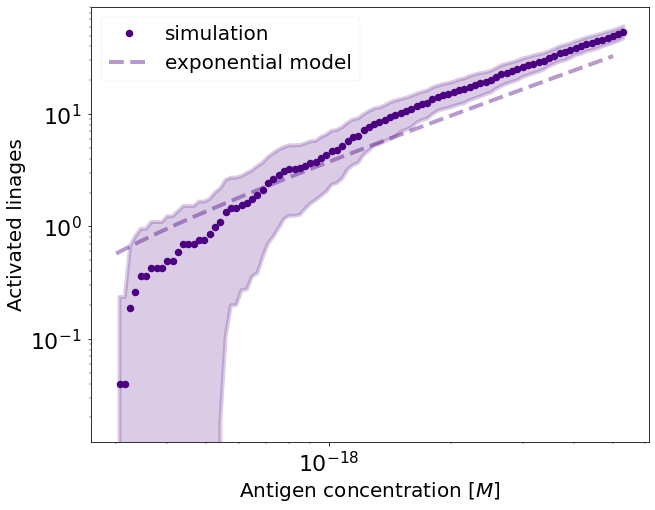

In [145]:

eo = np.min(energies)+energy_translation
to = (eo+np.log(N_A))/beta
#comment = 'left_tail_800k_birth'
print(to, np.exp(beta*to)/N_A)

fig, ax = plt.subplots(1, 1, figsize = (10,8))
plot_activation_rate_ensemble_deterministic(beta= beta, b= b, nu = nu, gamma = gamma, T = T,
                                            initial_time = initial_time, eo=e_0, n_linages = n_linages,
                                            n_left_tail = n_linages, rho_min = np.exp(beta*to)/N_A,
                                            rho_max = 5e-18, dt = dt, popt = popt,energies = energies,
                                            comment = comment, gaussian = False, exponential = True, ax = ax)
#ax.set_ylim(0.01, 50)
#fig.savefig('../Figures/ignited_linages_antigen_concentration_'+comment+'.png')

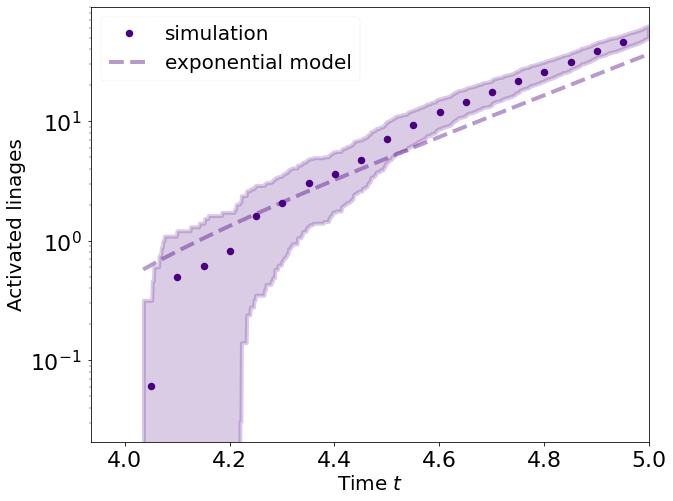

In [170]:

eo = np.min(energies)+energy_translation
to = (e_0+np.log(N_A))/beta
to2 = (eo+np.log(N_A))/beta


fig, ax = plt.subplots(1, 1, figsize = (10,8))
N_A = 6.02214076e23
#____________ Read and plot the activation of linages as function of antigen concetration
t_new = np.linspace(initial_time, T, int((T-initial_time)/dt))
t_new2 = np.linspace(to2, T, int((T-initial_time)/dt))

activation_time_series = pickle.load( open( "../../../../Dropbox/Research/Evolution_Immune_System//Text_files/ensemble_deterministic_model_activation_time_series_"+comment+".pkl", "rb" ) )
activation_time_series_var = pickle.load( open( "../../../../Dropbox/Research/Evolution_Immune_System//Text_files/ensemble_deterministic_model_activation_time_series_var_"+comment+".pkl", "rb" ) )

ax.plot(t_new[::100], activation_time_series[::100], linestyle = '', marker = '.', ms = 15, linewidth = 4, color = 'indigo', label = 'simulation')
ax.fill_between(t_new , activation_time_series - np.sqrt(activation_time_series_var), activation_time_series + np.sqrt(activation_time_series_var), linewidth = 4, color = 'indigo', alpha = 0.2)

tau = np.exp(t_new2-to)

ax.plot(t_new2, (1)*(1/(b*beta))*(tau**(b*beta)-(1/1)), linewidth = 4, linestyle = 'dashed', alpha = 0.4, label = 'exponential model', color = 'indigo')

ax.set_xlabel(r'Time $t$', fontsize = 20)
ax.set_ylabel(r'Activated linages', fontsize = 20)
ax.tick_params(labelsize = 22)
#ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_ylim(0.1, max(activation_time_series[1:]*1.5))
ax.set_xlim(to2-.1, T)
ax.legend(loc = 0, fontsize = 20)
#ax.set_ylim(0.01, 50)
fig.savefig('../Figures/ignited_linages_time_'+comment+'.png')

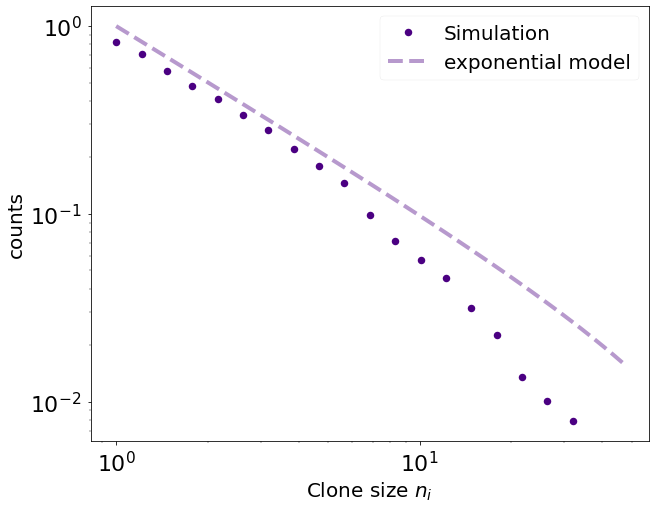

In [171]:
fig, ax = plt.subplots(1, 1, figsize = (10,8))
n_bins = 21
plot_size_distribution_ensemble_deterministic(beta= beta, b= b, nu = nu, gamma = gamma, T = T, eo = e_0, dt = dt,
                                              n_bins = n_bins, density = True, popt = popt, comment = comment,
                                              gaussian = False, exponential = True, ax = ax)

fig.savefig('../Figures/linages_size_distribution_'+comment+'.png')

(3.5, 6.0)

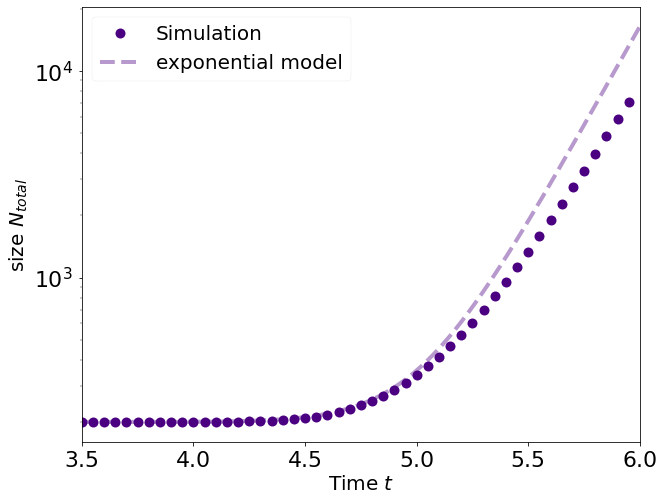

In [120]:
fig, ax = plt.subplots(1, 1, figsize = (10,8))
plot_N_total_ensemble_deterministic(beta= beta, b= b, nu = nu, gamma = gamma, T = T, initial_time = initial_time,
                                    eo = e_0 , n_linages = n_linages, n_left_tail = n_linages, dt = dt, 
                                    popt = popt, comment = comment, gaussian = False,exponential = True, ax = ax)

ax.set_xlim(initial_time, T)

#fig.savefig('../Figures/total_Bcell_pop_'+comment+'.png')

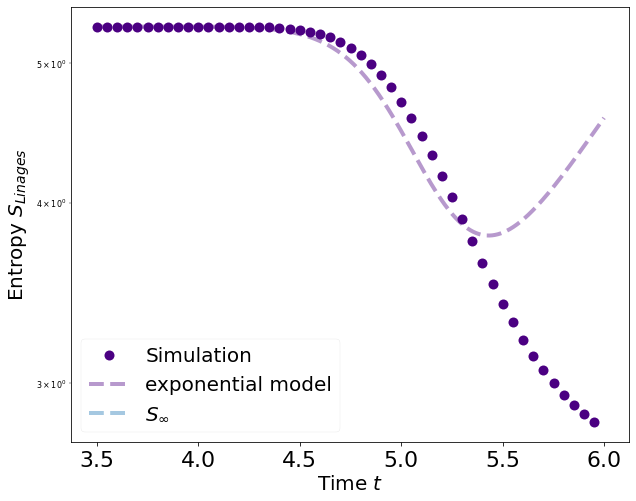

In [121]:
fig, ax = plt.subplots(1, 1, figsize = (10,8))
plot_entropy_ensemble_deterministic(beta = beta, b= b, nu = nu, gamma = gamma,  T = T, initial_time = initial_time,
                                    eo = e_0, n_linages = n_linages, n_left_tail = n_linages, dt = dt,
                                    popt = popt, comment = comment, gaussian = False, exponential = True,
                                    ax = ax)
#fig.savefig('../Figures/total_entropy_'+comment+'.png')

In [54]:
n_linages = 200
U = n_linages/n_seq
alpha = n_linages/len(Left_tail)

beta = np.linspace(2.5, 3.5, 5)[2]
print('beta:', beta)
gamma = np.logspace(-2, 0, 5)[2]
print('gamma:', gamma)
nu = np.linspace(.5, 4.5, 5)[3]
print('nu:', nu)

energy_translation = 0
initial_time = 3.5
dt = 0.001
T = 5
eo = np.min(energies)+energy_translation
to = (e_0+np.log(N_A))/beta

activated_energies = pickle.load( open( "../../../../Dropbox/Research/Evolution_Immune_System/Text_files/ensemble_deterministic_model_activated_energies_"+comment+".pkl", "rb" ) )

print(len(activated_energies))
#____________
fig, ax = plt.subplots(1, 1, figsize = (10,8))
distances_left_tail = plot_histogram_hamming_distance(Sequences = Left_tail, ax = ax)
plt.close()

fig, ax = plt.subplots(1,1,figsize=(10,8))
#energies_left_tail, data_energies_left_tail = plot_histogram_energy(Sequences = Left_tail, bins = 'auto' , ax = ax)
#ax.set_xlim(np.min(energies),np.min(energies)+4)
#____________

p_e = np.histogram(activated_energies, bins='auto', density = True)
ax.plot(np.exp(p_e[1][:-1]), p_e[0]/(1),  color = 'indigo', label = 'simulation', linestyle = '-', marker = '*', ms = 10)
e_new = np.linspace(np.min(energies),np.min(energies)+1.5, 100)
ax.plot(np.exp(e_new), np.exp(my_linear_func(e_new, 53, b)), linestyle  = 'dashed', linewidth = 3, color = 'darkblue', alpha = .5)
#ax.plot(e_new, np.exp(my_linear_func(e_new, *popt)), linestyle  = 'dashed', linewidth = 3, color = 'steelblue', alpha = .5)
#ax.hlines(n_linages/len(Left_tail), np.min(energies), np.min(energies) + 4, linestyle  = 'dashed', linewidth = 3, color = 'darkblue', alpha = .5)

p_0 = p_e[0][0]
#ax.plot(e_new, ((p_0)/(m_bar_theory))*(np.exp(-(1/b)*(e_new-e_0) + b*(e_new - e_0))))

#ax.set_xlabel(r'Energy $\epsilon$', fontsize = 20)
ax.set_xlabel(r'$K_D$', fontsize = 20)
ax.set_ylabel(r'$p(\epsilon)$', fontsize = 20)
ax.tick_params(labelsize = 22, which='both')
ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_xlim(np.min(energies),np.min(energies)+4)
ax.legend(loc = 0, fontsize = 20)
#fig.savefig('../Figures/probability_ignition_K_D_'+comment+'.png')


NameError: name 'Left_tail' is not defined

## Self-consistent solution for the number of activated clones before peak of viral load

beta: 3.0
gamma: 0.1
nu: 3.5
0.8905519891068013
9.69039039039039


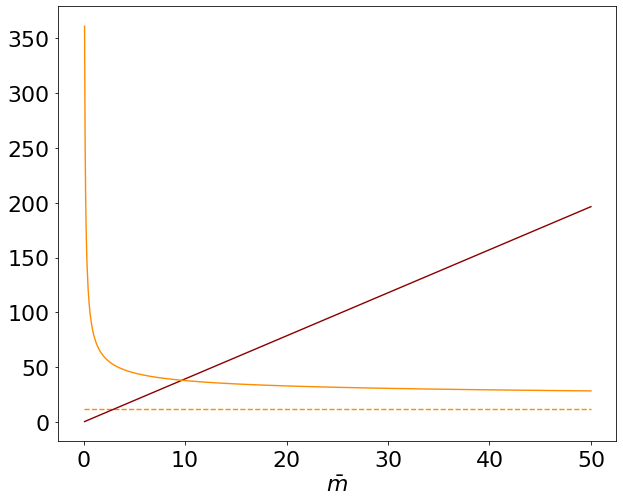

In [246]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
m_max = 50
m_array = np.linspace(.1, m_max,1000)

beta = np.linspace(2.5, 3.5, 5)[2]
print('beta:', beta)
gamma = np.logspace(-2, 0, 5)[2]
print('gamma:', gamma)
nu = np.linspace(.5, 4.5, 5)[3]
print('nu:', nu)

print(nu/(beta*b))
comment = 'left_tail_800k_birth_death_beta_%.2f_gamma_%.2e_nu_%.2f'%(beta, gamma, nu)

f1 = (m_array*beta*b)/(1)
f2 = ((beta*(beta*b-nu))/((gamma)*(1-(((m_array*beta*b)/(1))+1)**(((nu-beta*b)/(beta*b))))))-1

ax.plot(m_array, f1, color = 'darkred')
ax.plot(m_array, f2, color = 'darkorange')
if(nu/(beta*b)<1):
    ax.hlines((beta*(beta*b-nu))/(gamma)-1, .01, m_max, linestyle = 'dashed', color='darkorange')
else:
    ax.hlines(-1, .1, m_max, linestyle = 'dashed', color='darkorange')
ax.set_xlabel(r'$\bar{m}$', fontsize = 22)
ax.tick_params(labelsize = 22)
m_bar_theory = np.min((m_array)[(f1)>(f2)])
print(m_bar_theory)

1900
13.338947368421053 9.69039039039039


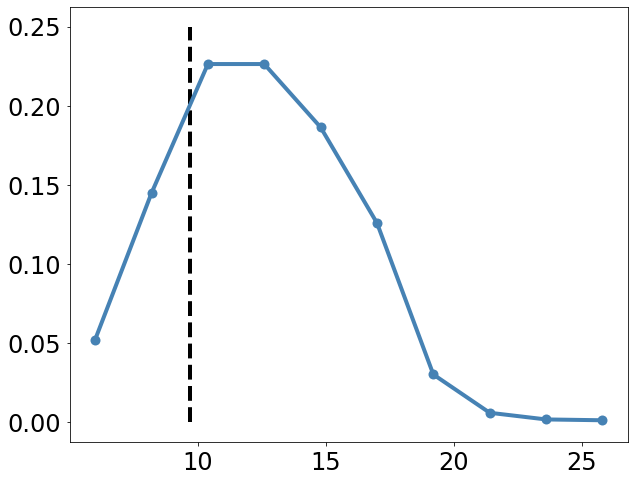

In [268]:
fig, ax = plt.subplots(1, 1, figsize = (10,8))
m_bar_stats = pickle.load( open("../../../../Dropbox/Research/Evolution_Immune_System/Text_files/ensemble_deterministic_model_m_bar_"+comment+".pkl", "rb") )
print(len(m_bar_stats))
energy_distrib = np.histogram(m_bar_stats, bins = 10, density = False)
ax.plot(energy_distrib[1][:-1], energy_distrib[0]/(len(m_bar_stats)), color = 'steelblue', linewidth = 4, linestyle = '-', marker = 'o', ms = 10)
ax.vlines(m_bar_theory, 0, .25, color = 'k', linewidth = 4, linestyle = 'dashed')
ax.tick_params(labelsize = 24)
fig.savefig('../Figures/m_bar_example.png')
print(np.mean(m_bar_stats), m_bar_theory)

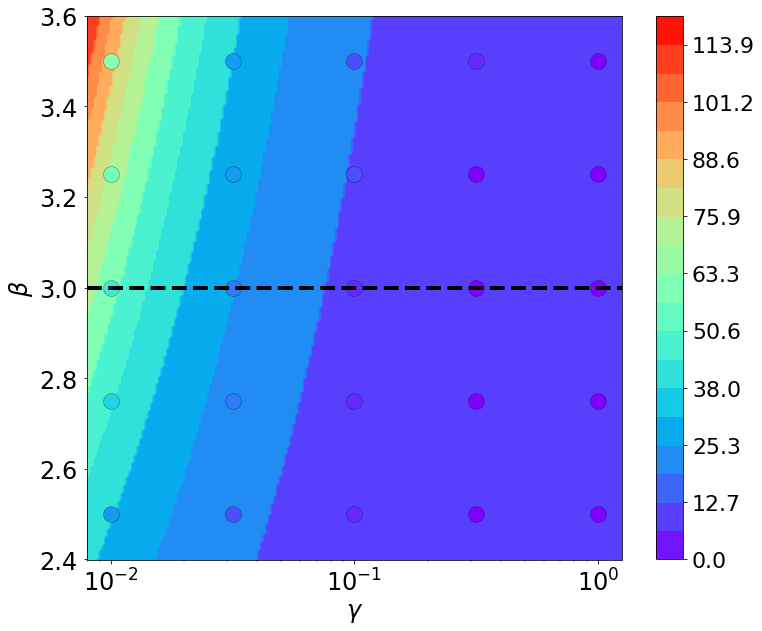

In [177]:
import matplotlib.ticker as ticker

m_max = 10000
m_array = np.linspace(.1, m_max,1000)

m_bar_matrix = np.zeros((200, 200))
 
betas = np.linspace(2.4, 3.6, 200)
gammas = np.logspace(-2.1, 0.1, 200)
nus = np.linspace(.5, 4.5, 5)
nu = 4

x, y = np.meshgrid(gammas, betas)

for i, beta  in enumerate(betas):
    for j, gamma in enumerate(gammas):
        
        f1 = (m_array*beta*b)
        f2 = ((beta*(beta*b-nu))/((gamma)*(1-(((m_array*beta*b)/(1))+1)**(((nu-beta*b)/(beta*b))))))-1
       
        m_bar_theory = np.min((m_array)[(f1)>(f2)])
    
        m_bar_matrix[i, j] = m_bar_theory

m_bar_max = np.max(m_bar_matrix)
fig, ax = plt.subplots(figsize = (12,10))
cs = ax.contourf(x, y, m_bar_matrix, cmap=plt.cm.rainbow, levels = np.linspace(0, m_bar_max, 20))
ax.hlines(3, gammas[0], gammas[-1], linestyle = 'dashed', linewidth = 4, color='k')


## Plot data from simulations
betas = np.linspace(2.5, 3.5, 5)
gammas = np.logspace(-2, 0, 5)
nus = np.linspace(.5, 4.5, 5)
nu = 4

for i, beta in enumerate (betas):
    for j, gamma in enumerate (gammas):
        comment = 'left_tail_800k_birth_death_beta_%.2f_gamma_%.2e_nu_%.2f'%(beta, gamma, nu)
        m_bar_stats = pickle.load( open("../../../../Dropbox/Research/Evolution_Immune_System/Text_files/ensemble_deterministic_model_m_bar_"+comment+".pkl", "rb") )
        ax.scatter(gamma, beta, color = plt.cm.rainbow(np.linspace(0, 1, 20))[int((19*np.mean(m_bar_stats))/m_bar_max)], edgecolors = 'k', s = 250)

#xlabels = ["{0:.0e}".format(x) for x in gammas]
#ylabels = ["{0:.1f}".format(x) for x in betas]
#ax.set_title(r'$\bar{m}$', fontsize = 26)
ax.tick_params(labelsize = 24)
#ax.set_yticklabels(np.flip(ylabels[::10]))
#ax.set_xticklabels(xlabels[::40])
ax.set_ylabel(r'$\beta$', fontsize = 24);
ax.set_xlabel(r'$\gamma$', fontsize = 24);
ax.set_xscale('log')
#ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
cbar = fig.colorbar(cs)
cbar.ax.tick_params(labelsize=22)
fig.savefig('../Figures/Ignited_clones_beta_gamma_sc_solution_nu_%.2f.png'%(nu))


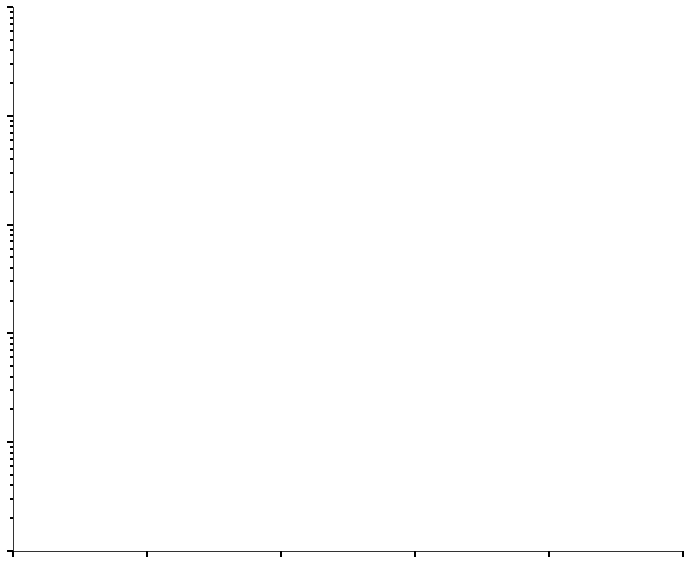

In [208]:
fig, ax = plt.subplots(figsize = (12,10))
x = np.linspace(0,10,100)
#ax.plot(x, np.exp(x), linewidth = 8, color = 'indigo', alpha = 0.7)
ax.set_yscale('log')
#ax.set_title(r'WT', fontsize = 32)

ax.tick_params(axis = 'y', which="major", width = 2, length = 6)
ax.tick_params(which="minor", width = 2, length = 3)
ax.tick_params(axis = 'x', width = 2, length = 6)


ax.set_yticklabels([])
ax.set_xticklabels([])
#ax.set_xlabel(r'Time $t$', fontsize = 30);
#ax.set_ylabel(r'Concentration', fontsize = 26);

ax.set_ylim(1,1e5)
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.savefig('../Figures/Axis.png')